C:\Users\Helen\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Helen\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 | Train Loss: 1.1722
Epoch 2/10 | Train Loss: 0.3579
Epoch 3/10 | Train Loss: 0.1805
Epoch 4/10 | Train Loss: 0.1322
Epoch 5/10 | Train Loss: 0.1042
Epoch 6/10 | Train Loss: 0.1525
Epoch 7/10 | Train Loss: 0.1204
Epoch 8/10 | Train Loss: 0.1062
Epoch 9/10 | Train Loss: 0.1557
Epoch 10/10 | Train Loss: 0.1453

Classification Report:
                    precision    recall  f1-score   support

Acadian_Flycatcher       0.92      1.00      0.96        12
     American_Crow       1.00      1.00      1.00        12
  Anna_Hummingbird       1.00      0.92      0.96        12
     Baird_Sparrow       1.00      1.00      1.00        10
  Baltimore_Oriole       1.00      1.00      1.00        12

          accuracy                           0.98        58
         macro avg       0.98      0.98      0.98        58
      weighted avg       0.98      0.98      0.98        58


Test Loss:
0.0416


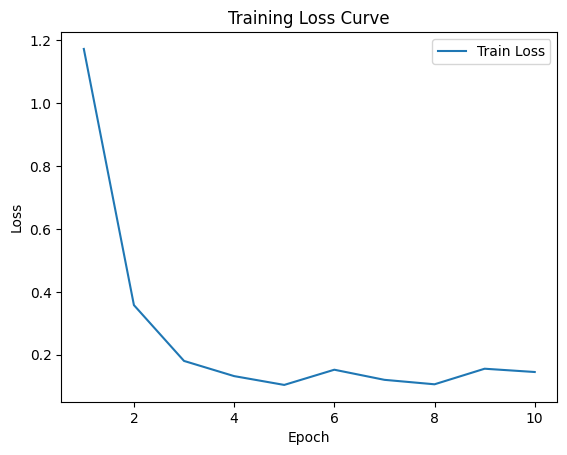

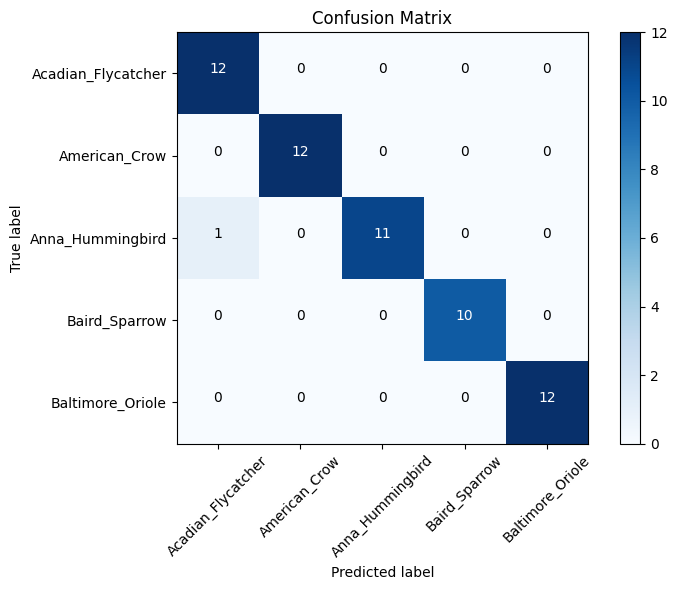

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

#the main info for model
train_dir = "C:\\Users\\Helen\\OneDrive\\Desktop\\Bapp\\Ctrain" #replace for own testing
test_dir = "C:\\Users\\Helen\\OneDrive\\Desktop\\Bapp\\Vtest"   #replace for own testing

num_classes = len(os.listdir(train_dir))  #r: this is for the class name being the folder
batch_size = 32
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#transforming the data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


#loding the dataset
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

#loading the model and final layer
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

#the loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#model training
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f}")

#model testing
model.eval()
all_preds = []
all_labels = []
running_test_loss = 0


with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item() * images.size(0)

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = running_test_loss / len(test_dataset)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes, zero_division=0))

print("\nTest Loss:")
print(f"{test_loss:.4f}")


#loss plotting
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curve')
plt.show()

#showing the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')

classes = test_dataset.classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()